In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-08 19:46:01.489929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 19:46:02.238786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In [2]:
# hardcoded stuff
df_path = "data/otu_table_example.csv"

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [3]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [4]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

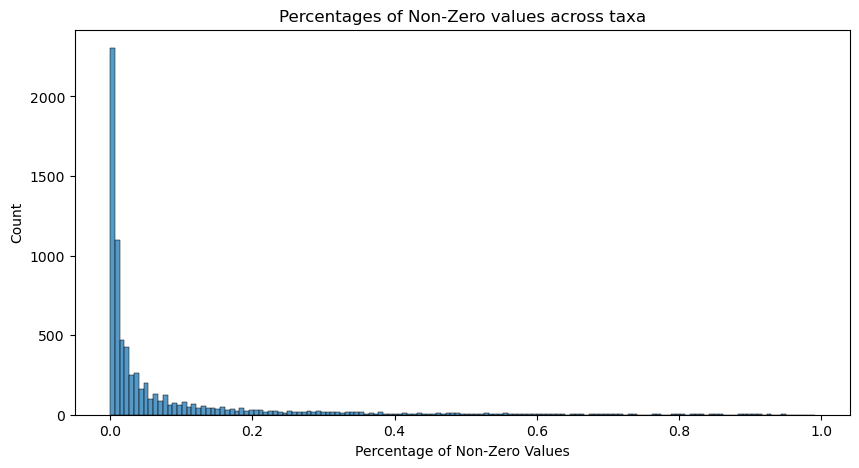

In [5]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [6]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

Here is how an example taxa with id 302746 looks like before preprocessing

In [7]:
zero_values_percentage_cutoff = 0.5 # at least 50% of taxa must be non-zero values
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-08 19:46:13.097366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 19:46:13.098182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 19:46:13.098588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 19:46:13.122052: I tensorflow/core/platform/cpu_featu

In [8]:
example_taxa_idx = 302746
example_taxa_sequence_raw = df[example_taxa_idx]

In [9]:
example_taxa_sequence_preprocessed = df[example_taxa_idx]
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


#### Here is what our example taxa sequence 302746 looks like after preprocessing

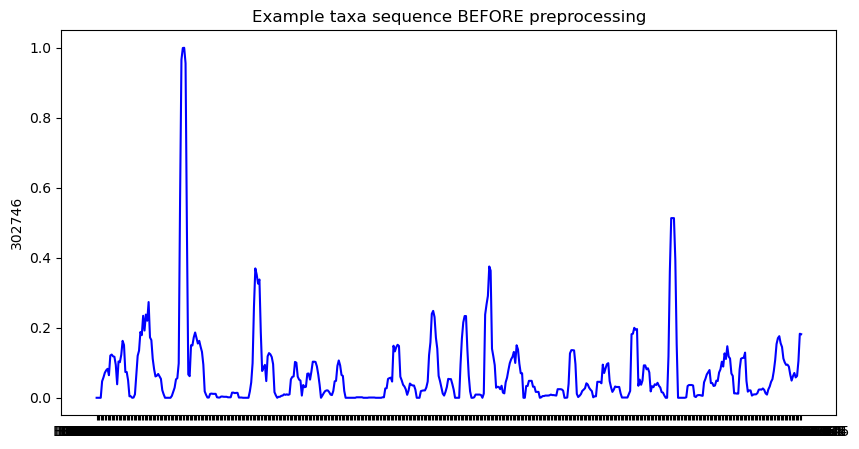

In [10]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_raw, color="blue", title="Example taxa sequence BEFORE preprocessing")

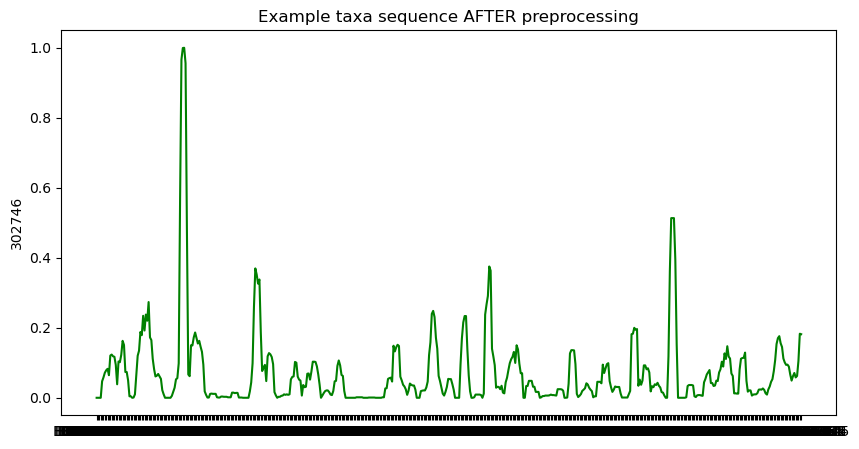

In [11]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_preprocessed, color="green", title="Example taxa sequence AFTER preprocessing")

### Features and Targets

Now I prepare feature sequences and target sequences. For a detailed description of how this happens please read the description to function cut_to_sequences(). You will find it in functions.py

Every sequence before cutoff is used for training. Every sequence after: for testing

In [12]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


### The Model

In [13]:
reg = 1e-12
loss=batch_mae_ignore_zeros

n_feats = len(df.columns)

model = Sequential()
model.add(keras.Input(shape=(seq_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-08 19:46:23.513327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 19:46:23.535808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 19:46:23.536119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5025792   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 202)               413898    
                                                                 
Total params: 7538890 (28.76 MB)
Trainable params: 7538890 (28.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [14]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=10)

Epoch 1/10


2023-10-08 19:46:28.107435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-08 19:46:28.151737: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f20bc025820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 19:46:28.151775: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-08 19:46:28.157060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 19:46:28.169504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-08 19:46:28.268302: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

13/13 [==============================] - 2s 59ms/step - loss: 26.8144 - mae: 0.1070 - mape: 4076173.7500 - val_loss: 22.7374 - val_mae: 0.0963 - val_mape: 2107294.0000
Epoch 2/10
13/13 [==============================] - 1s 45ms/step - loss: 19.7044 - mae: 0.0838 - mape: 2115276.2500 - val_loss: 18.0234 - val_mae: 0.0873 - val_mape: 1570907.0000
Epoch 3/10
13/13 [==============================] - 1s 45ms/step - loss: 15.5501 - mae: 0.0728 - mape: 1096658.6250 - val_loss: 15.5119 - val_mae: 0.0847 - val_mape: 1367961.6250
Epoch 4/10
13/13 [==============================] - 1s 45ms/step - loss: 13.0378 - mae: 0.0660 - mape: 1053915.0000 - val_loss: 13.3992 - val_mae: 0.0784 - val_mape: 895037.8750
Epoch 5/10
13/13 [==============================] - 1s 45ms/step - loss: 11.3397 - mae: 0.0606 - mape: 826398.1875 - val_loss: 13.1266 - val_mae: 0.0839 - val_mape: 1014760.1250
Epoch 6/10
13/13 [==============================] - 1s 46ms/step - loss: 10.1880 - mae: 0.0570 - mape: 770437.7500 - v

In [15]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 8ms/step


In [16]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [17]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [18]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.023844,0.000000,0.000000,0.000000,0.003462,0.198655,0.259538,0.188923,0.092166,0.255693,...,0.325641,0.108620,0.000000,0.175334,0.000000,0.289321,0.092651,0.232212,0.207183,0.183976
1,0.018564,0.000000,0.000000,0.000000,0.005172,0.187613,0.261700,0.195205,0.082827,0.264230,...,0.338789,0.100400,0.000000,0.189551,0.000000,0.290786,0.081360,0.233642,0.210592,0.190345
2,0.013092,0.000000,0.000000,0.000000,0.001995,0.159565,0.234636,0.182157,0.068462,0.244238,...,0.310206,0.083754,0.000000,0.187097,0.000000,0.261930,0.065664,0.208570,0.188444,0.184312
3,0.012044,0.000000,0.000000,0.000000,0.000000,0.159994,0.288051,0.180152,0.066933,0.261934,...,0.331112,0.085560,0.000000,0.188627,0.000000,0.314292,0.055138,0.251838,0.233858,0.186368
4,0.015100,0.000000,0.000000,0.000000,0.000000,0.132339,0.249117,0.144795,0.048278,0.215257,...,0.257041,0.071255,0.000000,0.163693,0.000000,0.273170,0.044853,0.217925,0.196786,0.168936
5,0.015965,0.000000,0.000000,0.000000,0.000000,0.117129,0.213397,0.125998,0.044629,0.186299,...,0.228453,0.060507,0.000000,0.147815,0.000000,0.238972,0.043170,0.188811,0.165899,0.157244
6,0.025549,0.000000,0.000000,0.000000,0.000000,0.121285,0.196009,0.105704,0.049144,0.164908,...,0.184671,0.073264,0.000000,0.139265,0.000000,0.225771,0.074726,0.174679,0.142099,0.134267
7,0.033778,0.000000,0.000000,0.000000,0.000000,0.125486,0.188007,0.097716,0.053500,0.156612,...,0.158903,0.089036,0.000000,0.142385,0.000000,0.223502,0.103593,0.166804,0.123609,0.119268
8,0.028063,0.000000,0.000000,0.015218,0.000000,0.129395,0.123641,0.071492,0.032855,0.111076,...,0.098792,0.104797,0.000000,0.125757,0.000000,0.167949,0.146849,0.123059,0.075438,0.099306
9,0.026986,0.000000,0.000000,0.025139,0.000000,0.134420,0.087796,0.052058,0.019320,0.081830,...,0.071403,0.121155,0.000000,0.112035,0.000000,0.139168,0.179706,0.100941,0.051162,0.079068


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [19]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 13, 6.435643564356436% of all taxa


The next section allows to examine individual true and predicted sequences

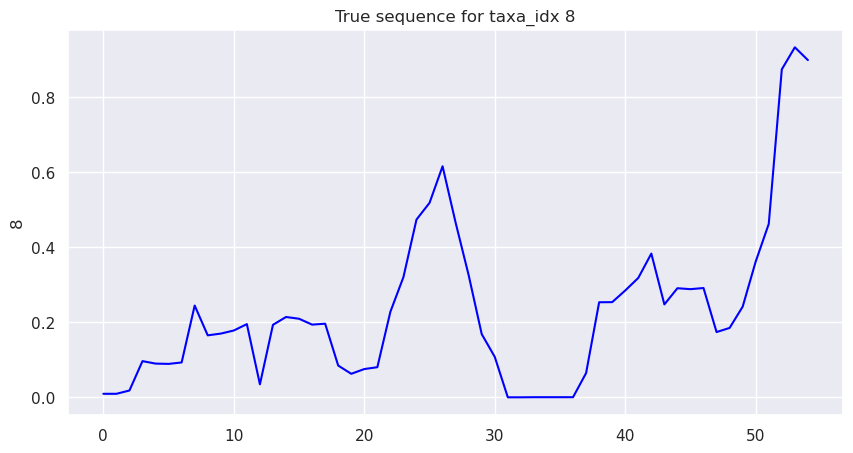

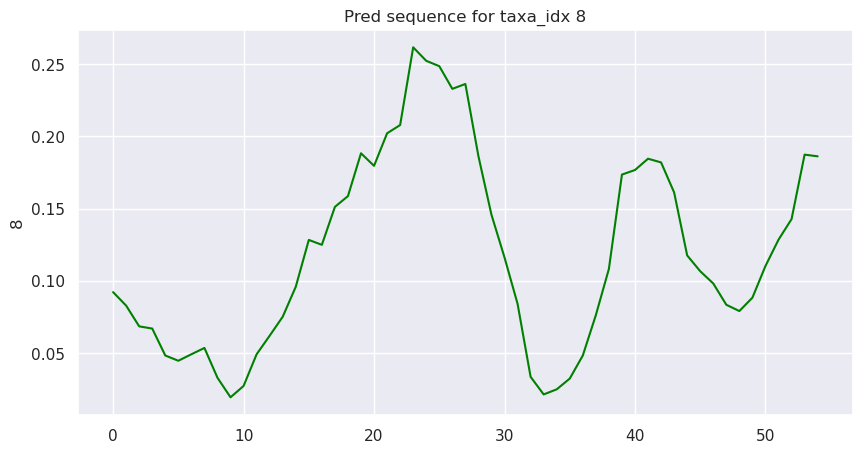

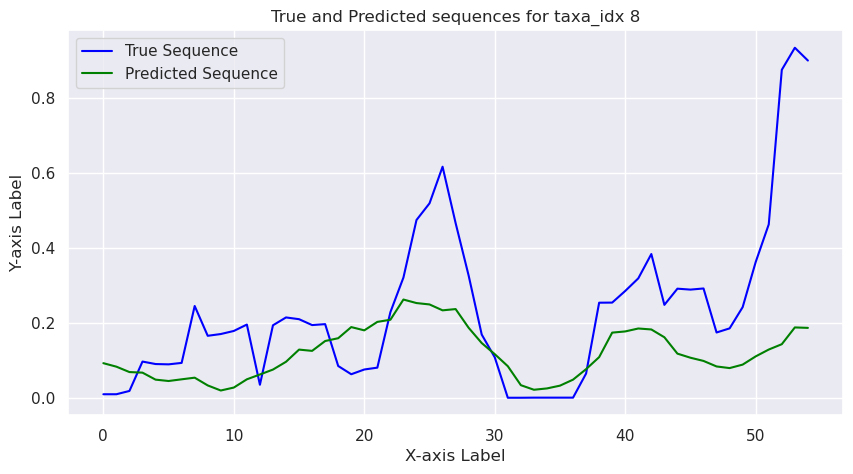

In [34]:
target_taxa = 8
true_sequence = y_test_df[target_taxa]
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [24]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,331584.285123,2249847427.535937,1596656196.028226,81600695.174555,635853621.104648,0.533016,0.751818,0.659556,1.464161,0.525107,...,0.617583,0.681854,250728441.585684,0.458991,425864158.088383,0.593680,0.690476,0.505703,8226304.257613,0.795843
std,1722661.749212,2965623042.675204,1361038444.567249,88438489.456558,540223267.295519,0.343187,0.433530,0.545826,1.507714,0.347332,...,0.601306,0.852127,441910612.398496,0.330011,409092334.996581,0.428503,0.819056,0.409658,60573128.142055,0.608114
min,0.031512,40543762.873899,0.000000,0.014646,21.777807,0.002006,0.014956,0.010150,0.072778,0.001741,...,0.007784,0.022800,0.463884,0.015856,0.375519,0.031061,0.000352,0.002569,0.052005,0.014154
25%,0.787930,160386356.074687,747126426.806401,9569377.862666,154277697.799919,0.228160,0.460268,0.335106,0.606845,0.263476,...,0.191989,0.172510,0.996375,0.149280,62540482.960309,0.350454,0.215807,0.135027,0.346749,0.393468
50%,0.970539,1148512812.167328,1264367799.210834,62200956.107327,532959319.672449,0.592626,0.734573,0.521262,0.988938,0.437636,...,0.518688,0.485783,28896861.896556,0.426192,311362261.595252,0.474231,0.404100,0.359231,0.723740,0.643290
75%,1.000000,2916510471.775547,2068965489.617728,133971290.077320,1030855526.208552,0.848728,0.968149,0.862752,1.607195,0.767122,...,0.920326,0.918705,355913015.692582,0.688878,671975153.521748,0.792895,1.000000,0.872201,1.556984,1.002955
max,9118540.911689,9999999866.485682,6091953941.652198,368421047.712630,1830294505.717225,1.000000,2.595209,3.277413,7.790162,1.437259,...,2.842667,4.698534,1731403641.968648,1.277800,1445355232.986282,2.001049,4.018137,1.763181,449277980.511839,2.781686


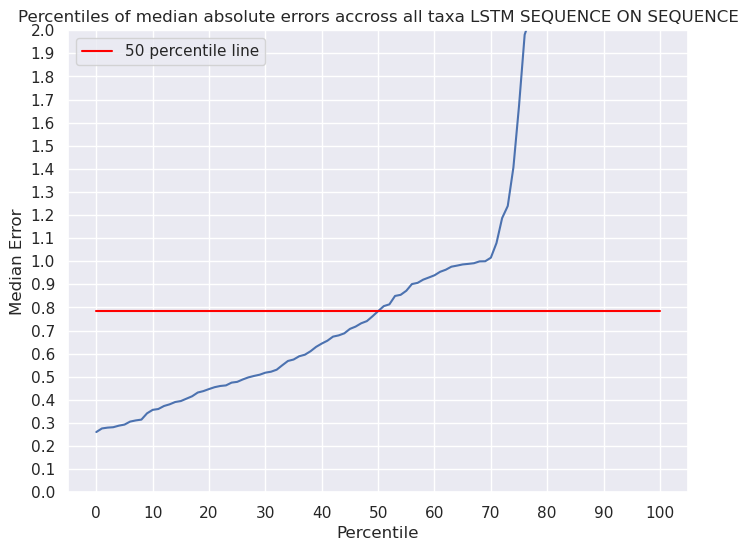

In [26]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [27]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,0,3,4,5,6,7,8,9,10,11,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,331584.285123,81600695.174555,635853621.104648,0.533016,0.751818,0.659556,1.464161,0.525107,0.800000,84679017.976112,...,0.617583,0.681854,250728441.585684,0.458991,425864158.088383,0.593680,0.690476,0.505703,8226304.257613,0.795843
std,1722661.749212,88438489.456558,540223267.295519,0.343187,0.433530,0.545826,1.507714,0.347332,0.545240,256734666.213561,...,0.601306,0.852127,441910612.398496,0.330011,409092334.996581,0.428503,0.819056,0.409658,60573128.142055,0.608114
min,0.031512,0.014646,21.777807,0.002006,0.014956,0.010150,0.072778,0.001741,0.018374,0.004064,...,0.007784,0.022800,0.463884,0.015856,0.375519,0.031061,0.000352,0.002569,0.052005,0.014154
25%,0.787930,9569377.862666,154277697.799919,0.228160,0.460268,0.335106,0.606845,0.263476,0.342712,0.381702,...,0.191989,0.172510,0.996375,0.149280,62540482.960309,0.350454,0.215807,0.135027,0.346749,0.393468
50%,0.970539,62200956.107327,532959319.672449,0.592626,0.734573,0.521262,0.988938,0.437636,0.848070,0.959590,...,0.518688,0.485783,28896861.896556,0.426192,311362261.595252,0.474231,0.404100,0.359231,0.723740,0.643290
75%,1.000000,133971290.077320,1030855526.208552,0.848728,0.968149,0.862752,1.607195,0.767122,1.063579,3.414673,...,0.920326,0.918705,355913015.692582,0.688878,671975153.521748,0.792895,1.000000,0.872201,1.556984,1.002955
max,9118540.911689,368421047.712630,1830294505.717225,1.000000,2.595209,3.277413,7.790162,1.437259,2.591722,1195734581.191629,...,2.842667,4.698534,1731403641.968648,1.277800,1445355232.986282,2.001049,4.018137,1.763181,449277980.511839,2.781686


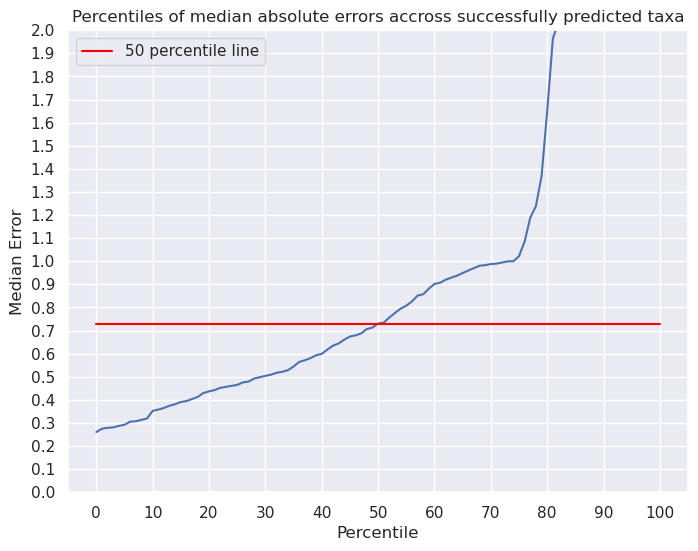

In [29]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=2)